In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helpers import find_duplicates
from scipy.stats import ttest_ind
from scipy import stats

# Project Milestone 2

This notebook contians initial data exploration and analysis for the Project Milestone 2.

____________________________

## Data Processing

### Loading the Data

In [2]:
# main data path and relative paths to the datasets
DATA_PATH = "data/"
DATA_PATH_MOVIESUMMARIES = DATA_PATH + "MovieSummaries/"
DATA_PATH_MOVIELENS = DATA_PATH + "MovieLens/"
DATA_PATH_IMDB = DATA_PATH + "IMDBData/"
DATA_PATH_FINANCIAL = DATA_PATH + "Financial/"

DATASET_PATH = {
    "movie_metadata": DATA_PATH_MOVIESUMMARIES + "movie.metadata.tsv",
    "movie_budget": DATA_PATH_MOVIELENS + "movies_metadata.csv",
    "imdb_ratings": DATA_PATH_IMDB + "title.ratings.tsv",
    "imdb_basics": DATA_PATH_IMDB + "title.basics.tsv",
    "cpi_data": DATA_PATH_FINANCIAL + "CPI.csv",
    "gdp_data": DATA_PATH_FINANCIAL + "GDP.csv",
}
DATASET_COLUMNS = {
    "movie_metadata": [
        "wikipedia_id",
        "freebase_movie_id",
        "title",
        "release_date",
        "revenue",
        "runtime",
        "languages",
        "countries",
        "genres",
    ],
    "movie_budget": [
        "budget",
        "imdb_id",
        "original_title",
        "popularity",
        "release_date",
        "revenue",
        "runtime",
        "title",
        "vote_average",
        "vote_count",
    ],
    "imdb_ratings": ["imdb_id", "imdb_rating", "num_votes"],
    "imdb_basics": [
        "imdb_id",
        "title_type",
        "primary_title",
        "title",
        "is_adult",
        "year",
        "end_year",
        "runtime",
        "genres",
    ],
}

In [3]:
# data types for the datasets
DATASET_TYPES = {
    "movie_metadata": {
        "wikipedia_id": "string",
        "freebase_movie_id": "string",
        "title": "string",
        "release_date": "string",
        "revenue": "float64",
        "runtime": "string",
        "languages": "object",
        "countries": "object",
        "genres": "object",
    },
    "movie_budget": {
        "budget": "object",
        "imdb_id": "string",
        "original_title": "object",
        "popularity": "object",
        "release_date": "object",
        "revenue": "float64",
        "runtime": "string",
        "title": "object",
        "vote_average": "float64",
        "vote_count": "float64",
    },
    "imdb_ratings": {
        "imdb_id": "string",
        "imdb_rating": "float64",
        "num_votes": "int64",
    },
    "imdb_basics": {
        "imdb_id": "string",
        "title_type": "string",
        "primary_title": "string",
        "title": "string",
        "is_adult": "string",
        "year": "string",
        "end_year": "string",
        "runtime": "string",
        "genres": "string",
    },
}

In [4]:
# load the datasets as pandas dataframes
movie_metadata = pd.read_csv(
    DATASET_PATH["movie_metadata"],
    sep="\t",
    names=DATASET_COLUMNS["movie_metadata"],
    index_col=False,
    header=None,
    dtype=DATASET_TYPES["movie_metadata"],
)
movie_budget = pd.read_csv(
    DATASET_PATH["movie_budget"],
    sep=",",
    usecols=DATASET_COLUMNS["movie_budget"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["movie_budget"],
)
imdb_ratings = pd.read_csv(
    DATASET_PATH["imdb_ratings"],
    sep="\t",
    names=DATASET_COLUMNS["imdb_ratings"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["imdb_ratings"],
)
imdb_basics = pd.read_csv(
    DATASET_PATH["imdb_basics"],
    sep="\t",
    names=DATASET_COLUMNS["imdb_basics"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["imdb_basics"],
)
cpi_data = pd.read_csv(
    DATASET_PATH["cpi_data"],
    sep=",",
    index_col=False,
    skiprows=4,
    header=0,
)
gdp_data = pd.read_csv(
    DATASET_PATH["gdp_data"],
    sep=",",
    index_col=False,
    skiprows=4,
    header=0,
)

In [5]:
# print the shapes of the datasets
print("Movie Metadata Shape: ", movie_metadata.shape)
print("MovieLens Budget Shape: ", movie_budget.shape)
print("IMDB Ratings Shape: ", imdb_ratings.shape)
print("IMDB Basics Shape: ", imdb_basics.shape)
print("CPI Data Shape: ", cpi_data.shape)
print("GDP Data Shape: ", gdp_data.shape)

Movie Metadata Shape:  (81741, 9)
MovieLens Budget Shape:  (45466, 10)
IMDB Ratings Shape:  (1368131, 3)
IMDB Basics Shape:  (10309011, 9)
CPI Data Shape:  (266, 68)
GDP Data Shape:  (266, 68)


### Data Handling

##### Dataset: `movie_metadata`

In [6]:
print(
    "Total amount of rows that contain a NaN value: ",
    movie_metadata.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": movie_metadata.isna().sum(),
        "nan_percentage": movie_metadata.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  73498


,nan_sum,nan_percentage
wikipedia_id,0,0.000000
freebase_movie_id,0,0.000000
title,0,0.000000
release_date,6902,8.443743
revenue,73340,89.722416
runtime,20450,25.018045
languages,0,0.000000
countries,0,0.000000
genres,0,0.000000


We are mainly interested in the box office revenue, so we will drop all rows where this value is missing.
Additionally, we want to merge the CMU movies dataset with the IMDB dataset on title, year and runtime, so we need to drop the rows with missing values in these columns as well.

In [7]:
movie_metadata = movie_metadata.dropna(subset=["revenue", "release_date", "runtime"])

# runtime was converted from float to string, so the ".0" needs to be removed
movie_metadata["runtime"] = movie_metadata["runtime"].astype(str).str.replace(".0", "")

# make a column year extracting the year from the release date
movie_metadata["year"] = movie_metadata["release_date"].str[:4]

We need to check for duplicates in order to only have unique movies in the dataset.

In [8]:
# see if there are any duplicates in the movie metadata dataset
find_duplicates(movie_metadata, ["title", "release_date", "runtime"])

"No duplicates found in the specified columns: ['title', 'release_date', 'runtime']"

In [9]:
display(movie_metadata.head())

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres,year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1999


##### Dataset: `movie_budget`

We will use this external dataset to append the budget of the movies to our main movie dataset. This would help us to better understand the correlation between the budget and the revenue of the movies and explore the profitability of the movies.

In [10]:
# the nans in this dataset are represented as "\\N" in the csv file, so we need to replace them with np.nan
movie_budget = movie_budget.replace("\\N", np.nan)

print(
    "Total amount of rows that contain a NaN value: ",
    movie_budget.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": movie_budget.isna().sum(),
        "nan_percentage": movie_budget.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  348


,nan_sum,nan_percentage
budget,0,0.000000
imdb_id,17,0.037391
original_title,0,0.000000
popularity,5,0.010997
release_date,87,0.191352
revenue,6,0.013197
runtime,263,0.578454
title,6,0.013197
vote_average,6,0.013197
vote_count,6,0.013197


In [11]:
# drop all rows with missing values in the imdb_id column
movie_budget = movie_budget.dropna(subset=["imdb_id"])

# drop the columns which are present in movie_metadata
movie_budget = movie_budget.drop(
    columns=["original_title", "revenue", "release_date", "runtime", "title"]
)

# convert to float, non-convertible values become NaN
movie_budget["budget"] = pd.to_numeric(movie_budget["budget"], errors="coerce")
movie_budget.dropna(subset=["budget"], inplace=True)

In [12]:
find_duplicates(movie_budget, ["imdb_id"]).head(10)

,budget,imdb_id,popularity,vote_average,vote_count
38871,0.0,tt0022537,0.002362,0.0,0.0
16167,0.0,tt0022537,0.002362,0.0,0.0
949,4.0,tt0022879,1.914697,6.2,29.0
15074,4.0,tt0022879,2.411191,6.2,29.0
838,0.0,tt0046468,0.096079,0.0,0.0
30001,0.0,tt0046468,0.619388,0.0,0.0
7345,0.0,tt0062229,9.091288,7.9,187.0
9165,0.0,tt0062229,9.091288,7.9,187.0
29374,0.0,tt0067306,0.187901,8.0,3.0
15702,0.0,tt0067306,0.187901,8.0,3.0


In [13]:
# drop duplicates since there are some movies with the same imdb id
movie_budget = movie_budget.drop_duplicates(subset=["imdb_id"])

In [14]:
display(movie_budget.head())

,budget,imdb_id,popularity,vote_average,vote_count
0,30000000.0,tt0114709,21.946943,7.7,5415.0
1,65000000.0,tt0113497,17.015539,6.9,2413.0
2,0.0,tt0113228,11.7129,6.5,92.0
3,16000000.0,tt0114885,3.859495,6.1,34.0
4,0.0,tt0113041,8.387519,5.7,173.0


##### Dataset: `imdb_ratings`

In [15]:
# the nans in this dataset (if any) are represented as "\\N" in the csv file, so we need to replace them
imdb_ratings = imdb_ratings.replace("\\N", np.nan)

print(
    "Total amount of rows that contain a NaN value: ",
    imdb_ratings.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": imdb_ratings.isna().sum(),
        "nan_percentage": imdb_ratings.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  0


,nan_sum,nan_percentage
imdb_id,0,0.0
imdb_rating,0,0.0
num_votes,0,0.0


In [16]:
find_duplicates(imdb_ratings, ["imdb_id"])

"No duplicates found in the specified columns: ['imdb_id']"

In [17]:
display(imdb_ratings.head())

,imdb_id,imdb_rating,num_votes
0,tt0000001,5.7,2007
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2691


##### Dataset: `imdb_basics`

In [18]:
# # the nans in this dataset are represented as "\\N" in the csv file, so we need to replace them
imdb_basics = imdb_basics.replace("\\N", np.nan)

print(
    "Total amount of rows that contain a NaN value: ",
    imdb_basics.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": imdb_basics.isna().sum(),
        "nan_percentage": imdb_basics.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  10255916


,nan_sum,nan_percentage
imdb_id,0,0.000000
title_type,0,0.000000
primary_title,17,0.000165
title,17,0.000165
is_adult,1,0.000010
year,1381604,13.401906
end_year,10194381,98.888060
runtime,7203485,69.875617
genres,460237,4.464415


We will drop all rows with missing values in the title, year and runtime columns, since we are joining the movie_metadata on these keys later

In [20]:
imdb_basics = imdb_basics.dropna(subset=["title", "year", "runtime"])

# drop the columns which are present in movie_metadata and column end_year since it is almost always NaN
imdb_basics = imdb_basics.drop(columns=["end_year", "genres"])

In [23]:
find_duplicates(imdb_ratings, ["imdb_id"])

"No duplicates found in the specified columns: ['imdb_id']"

In [24]:
display(imdb_basics.head())

,imdb_id,title_type,primary_title,title,is_adult,year,runtime
0,tt0000001,short,Carmencita,Carmencita,0,1894,1
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1


##### Dataset: `us_cpi`

In [25]:
# since revenue, budget are in USD we only need the inflation data for the US
us_cpi = cpi_data[cpi_data["Country Name"] == "United States"]

# drop last column and other columns that are not needed
us_cpi = us_cpi.drop(
    columns=["Unnamed: 67", "Indicator Name", "Indicator Code", "Country Code"]
)

# drop columns with year > 2012, since we only need have movie data until 2012
us_cpi = us_cpi.drop(columns=us_cpi.columns[us_cpi.columns > "2012"])

# transpose the dataframe
us_cpi = us_cpi.transpose().reset_index()

# rename column index to year and column 251 to cpi
us_cpi = us_cpi.rename(columns={"index": "year", 251: "cpi"})

In [26]:
display(us_cpi.head())

,year,cpi
0,1960,13.563061
1,1961,13.708284
2,1962,13.872615
3,1963,14.044590
4,1964,14.224207


##### Dataset: `us_gdp`

In [27]:
# since revenue, budget are in USD we only need the data for the US
us_gdp = gdp_data[gdp_data["Country Name"] == "United States"]

# drop last column and other columns that are not needed
us_gdp = us_gdp.drop(
    columns=["Unnamed: 67", "Indicator Name", "Indicator Code", "Country Code"]
)

# drop columns with year > 2012
us_gdp = us_gdp.drop(columns=us_gdp.columns[us_gdp.columns > "2012"])

# transpose the dataframe
us_gdp = us_gdp.transpose().reset_index()

# rename column index to year and column 251 to gdp
us_gdp = us_gdp.rename(columns={"index": "year", 251: "gdp"})

# drop first row since it contains the column names
us_gdp = us_gdp.drop([0])

In [28]:
display(us_gdp.head())

,year,gdp
1,1961,5.633000e+11
2,1962,6.051000e+11
3,1963,6.386000e+11
4,1964,6.858000e+11
5,1965,7.437000e+11


### Expanding and merging the data

Now that we have cleaned all of the datasets, we can enrich the initial movie dataset with the external datasets.

First we will merge the `imdb_ratings` and `imdb_basics` dataframes, in order to complete the imdb dataset.
After that, we will expand the newly created imdb dataset with `movie_budget` data.

In [29]:
# merge the imdb datasets
imdb_dataset_temp = pd.merge(imdb_basics, imdb_ratings, on="imdb_id", how="left")
# populate imdb dataset with movie budget data
imdb_dataset = pd.merge(
    imdb_dataset_temp,
    movie_budget,
    on="imdb_id",
    how="left",
)
display(imdb_dataset.head())

,imdb_id,title_type,primary_title,title,is_adult,year,runtime,imdb_rating,num_votes,budget,popularity,vote_average,vote_count
0,tt0000001,short,Carmencita,Carmencita,0,1894,1,5.7,2007.0,0.0,1.273072,4.9,18.0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5,5.8,269.0,NaN,NaN,NaN,NaN
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4,6.5,1909.0,0.0,0.673164,6.1,19.0
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12,5.5,178.0,NaN,NaN,NaN,NaN
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1,6.2,2691.0,0.0,1.061591,5.8,19.0


Next, we will merge the imdb_dataset containing the budget, with the `movie_metadata` dataset. We will do this by using the movie title, runtime, and release year as a key.

In [30]:
movies_merged = pd.merge(
    movie_metadata,
    imdb_dataset,
    on=["title", "year", "runtime"],
    how="left",
)
display(movies_merged.head())

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres,year,imdb_id,title_type,primary_title,is_adult,imdb_rating,num_votes,budget,popularity,vote_average,vote_count
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,movie,Ghosts of Mars,0,4.9,56918.0,28000000.0,7.058599,4.8,299.0
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,tt0029852,movie,Alexander's Ragtime Band,0,6.8,2268.0,2000000.0,0.632261,4.8,6.0
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,tt0097499,movie,Henry V,0,7.5,31200.0,9000000.0,7.307967,7.4,73.0
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,tt0058331,movie,Mary Poppins,0,7.8,181780.0,6000000.0,15.11549,7.4,1217.0
4,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1999,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN


### Inflation-adjusted Revenue and Budget According to CPI

The earliest year for GDP is 1961, so we drop all movies before 1961 

In [34]:
movies_merged = movies_merged[movies_merged["year"] >= "1961"]

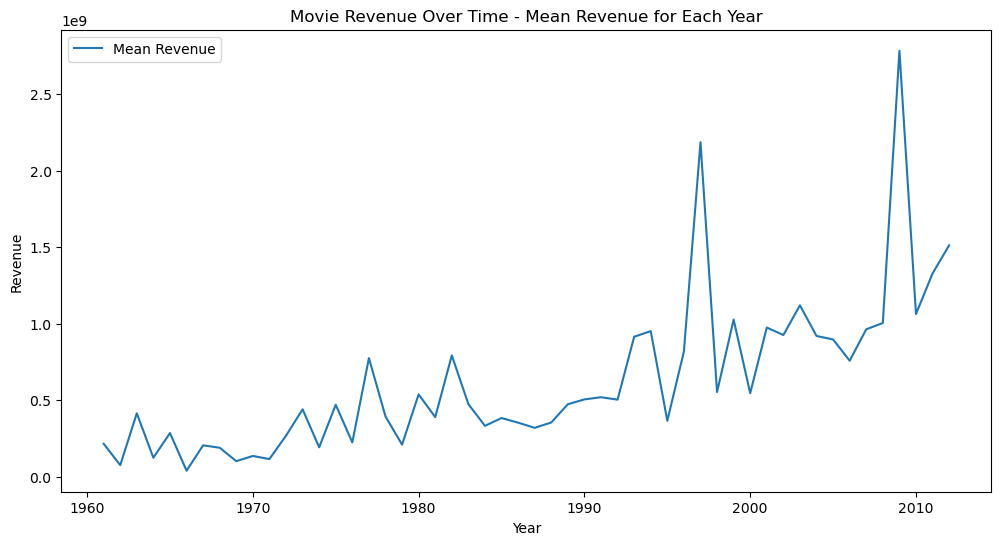

In [35]:
# plot the mean revenue for each year
mean_revenue = movies_merged.groupby(pd.to_datetime(movies_merged["year"]))[
    ["revenue"]
].max()

plt.figure(figsize=(12, 6))
plt.plot(mean_revenue.index, mean_revenue["revenue"], label="Mean Revenue")
plt.title("Movie Revenue Over Time - Mean Revenue for Each Year")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.legend()
plt.show()

As we can see, the mean revenue per year is increasing over time. To accurately compare movie revenues over time, we need to account for inflation. Without this adjustment, comparing movies from different eras becomes misleading. Older movies, which might have been very successful, will seem less profitable due to the lower ticket prices at their time.

The Consumer Price Index is calculated by measuring the price in one period for a fixed basket of consumer goods and services compared to previous periods.

- **Formula**: 
  $$ \text{Adjusted Value} = \left( \frac{\text{Current Value}}{\text{CPI in Current Year}} \right) \times \text{CPI Base Year} $$

- `Current Value`: The original revenue or budget of the movie.
- `CPI in Current Year`: The Consumer Price Index in the year the movie was released.
- `CPI Base Year`: The Consumer Price Index in the base year (2012).


We'll add two new columns to the dataset, one for the revenue adjusted for inflation and one for the budget adjusted for inflation.

In [36]:
# as our base year we choose 2012
cpi_base_year = us_cpi[us_cpi["year"] == "2012"]["cpi"].values[0]

# merge the movies_merged dataset with the us_inflation dataset on the year column
movies_merged = pd.merge(movies_merged, us_cpi, left_on="year", right_on="year")

# calculate adjusted revenue and budget according to the formula
movies_merged["revenue_adjusted"] = (
    movies_merged["revenue"] / movies_merged["cpi"]
) * cpi_base_year
movies_merged["budget_adjusted"] = (
    movies_merged["budget"] / movies_merged["cpi"]
) * cpi_base_year

Next we'll plot the original revenue and the inflation-adjusted revenue over time, in order to see the difference.

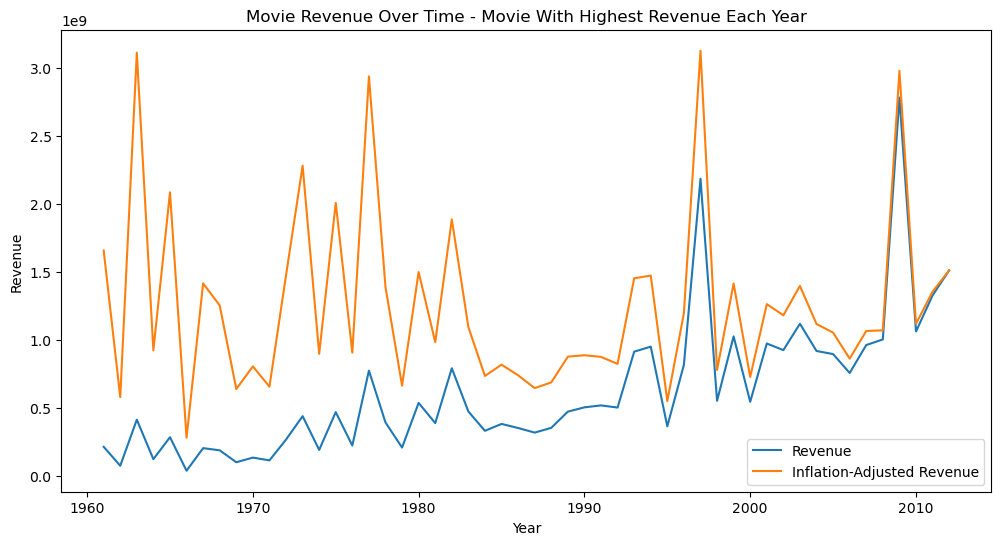

In [37]:
# group by year and get the movie with max revenue and revenue_inflation
annual_revenue = movies_merged.groupby(pd.to_datetime(movies_merged["year"]))[
    ["revenue", "revenue_adjusted"]
].max()

plt.figure(figsize=(12, 6))
plt.plot(annual_revenue.index, annual_revenue["revenue"], label="Revenue")
plt.plot(
    annual_revenue.index,
    annual_revenue["revenue_adjusted"],
    label="Inflation-Adjusted Revenue",
)
plt.title("Movie Revenue Over Time - Movie With Highest Revenue Each Year")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.legend()
plt.show()

From the plot we can see the revenues of the highest-grossing movie of each year with their inflation-adjusted equivalents. 
As we expected,  the inflation-adjusted revenues are higher than the reported revenues as the value of money decreases over time due to inflation. We can also see that the impact of inflation is more pronounced in earlier decades, as seen by the greater distance between the two lines.

After adjusting the revenue for inflation, the peaks in the revenue trends become more pronounced. We can see that some older movies actually have higher inflation-adjusted revenues than newer ones, which wouldn't be apparent if we only looked at nominal revenues.

In [38]:
top_movies = movies_merged.sort_values(by=["revenue_adjusted"], ascending=False).head(5)
top_movies = top_movies[["title", "year", "revenue", "revenue_adjusted"]]
top_movies

,title,year,revenue,revenue_adjusted
3533,Titanic,1997,2.185372e+09,3.125832e+09
6830,Love with the Proper Stranger,1963,4.150049e+08,3.111268e+09
1837,Avatar,2009,2.782275e+09,2.977544e+09
7037,Star Wars Episode IV: A New Hope,1977,7.753980e+08,2.937330e+09
7048,The Exorcist,1973,4.410710e+08,2.280793e+09


The movie with the highest nominal revenue is Avatar from 2009, with a revenue of approximately $2.782 billion. However, when we adjust for inflation, Titanic from 1997 shows a greater revenue than Avatar - an adjusted revenue of approximately $3.126 billion, compared to Avatar's adjusted revenue of about $2.978 billion.

Now we want to see if 'older' movies have a higher revenue than 'newer' movies. We define 'older' movies as movies that were released before 2000 and 'newer' movies as movies that were released after 2000

In [40]:
old_movies_revenues = movies_merged[movies_merged["year"].astype(int) < 2000][
    "revenue_adjusted"
]
new_movies_revenues = movies_merged[movies_merged["year"].astype(int) >= 2000][
    "revenue_adjusted"
]

print("Number of movies before 2000: ", len(old_movies_revenues))
print("Number of movies after 2000: ", len(new_movies_revenues))

Number of movies before 2000:  3537
Number of movies after 2000:  3641


In [41]:
mean_revenue_old = old_movies_revenues.mean()
mean_revenue_new = new_movies_revenues.mean()

# perform a t-test to see if the mean revenue of old movies is significantly higher than the mean revenue of new movies
t = ttest_ind(old_movies_revenues.values, new_movies_revenues.values)
print("Independent sample t-test: \n t =", t.statistic, "\n p =", t.pvalue)
print(
    "Mean revenue for older movies =",
    "{:.3f}".format(mean_revenue_old),
    "\nMean revenue for newer movies =",
    "{:.3f}".format(mean_revenue_new),
)

Independent sample t-test: 
 t = 3.0527201343754853 
 p = 0.0022760745178851327
Mean revenue for older movies = 89618796.442 
Mean revenue for newer movies = 76972127.711


The independent sample t-test results indicate that there is a statistically significant difference between the mean revenues of older movies (released before the year 2000) and newer movies (released in or after the year 2000). Given these results, we can conclude that older movies have a significantly higher mean revenue than newer movies when adjusted for inflation.

We can also plot the original budget and the inflation-adjusted budget over time, in order to see the difference.

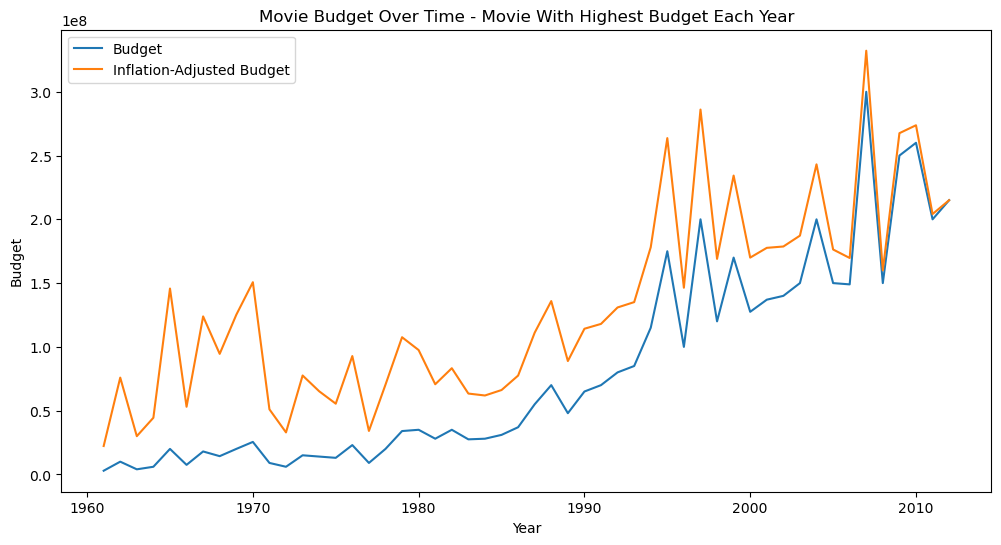

In [42]:
# group by year and get the movie with max budget and revenue_inflation
annual_revenue = movies_merged.groupby(pd.to_datetime(movies_merged["year"]))[
    ["budget", "budget_adjusted"]
].max()

plt.figure(figsize=(12, 6))
plt.plot(annual_revenue.index, annual_revenue["budget"], label="Budget")
plt.plot(
    annual_revenue.index,
    annual_revenue["budget_adjusted"],
    label="Inflation-Adjusted Budget",
)
plt.title("Movie Budget Over Time - Movie With Highest Budget Each Year")
plt.xlabel("Year")
plt.ylabel("Budget")
plt.legend()
plt.show()

Again as expected, the inflation-adjusted budgets are consistently higher than the nominal budgets, illustrating the impact of inflation over time. Both the nominal and inflation-adjusted budget lines show an overall upward trend, indicating that the budgets for the high-budget movies per year have been increasing over the decades.

We'll do a pearson correlation between the budget and year to see if there is actually a correlation between the two.

In [43]:
movies_merged_with_budgets = movies_merged.dropna(subset=["budget_adjusted"])
pearson_corr_coefficient, p_value = stats.pearsonr(
    movies_merged_with_budgets["year"].astype(float),
    movies_merged_with_budgets["budget_adjusted"],
)

print(f"Pearson's correlation coefficient: {pearson_corr_coefficient}")
print(f"P-value: {p_value}")

Pearson's correlation coefficient: 0.19802094707414603
P-value: 3.99341715311617e-27


This indicates a statistically significant positive linear relationship between the year of the movie's release and its inflation-adjusted budget.

The overall upward trend in both nominal and inflation-adjusted movie budgets could be related to broader economic growth, such as increases in Gross Domestic Product (GDP). As the economy grows, the movie industry grows with it.

### GDP Data ...

In [44]:
display(us_gdp.head())

,year,gdp
1,1961,5.633000e+11
2,1962,6.051000e+11
3,1963,6.386000e+11
4,1964,6.858000e+11
5,1965,7.437000e+11


---

TODO: 
***Inflation Adjustment and Comparative Analysis of Movie Revenues:***
- When adjusted for inflation, how does the gross revenue of older movies compare to recent modern movies?
- 


TODO: ***Which factors determine the movie's financial success?***
- Do movies with higher budgets produce higher revenues?
- How do runtime and genre impact a movie's revenue?


TODO: ***Is there a correlation between cinema revenue growth and world economic growth?***
- How does the increase in cinema gross revenue correlate with global economic growth indicators like the world's GDP?
- Are there regional differences in this correlation, and if so, which regions show a stronger relationship?
